In [1]:
import os
os.chdir('../')
%pwd

'/Users/uvaishnav/stress_detection'

In [2]:
import numpy as np
from scipy import signal
from scipy.signal import butter, lfilter, filtfilt
from typing import Tuple, Dict, List
import pandas as pd

from StressDetection.entity.entity import SignalProcessingConfig
import joblib

Kalman Filter

In [9]:
def kalman_filter(signal: np.ndarray) -> np.ndarray:
        """Apply Kalman filtering to the signal."""
        n = len(signal)
        Q = 1e-5  # Process variance
        R = 0.1**2  # Estimate of measurement variance, change to see effect

        xhat = np.zeros(n)  # a posteri estimate of x
        P = np.zeros(n)  # a posteri error estimate
        xhatminus = np.zeros(n)  # a priori estimate of x
        Pminus = np.zeros(n)  # a priori error estimate
        K = np.zeros(n)  # gain or blending factor

        # initial guesses
        xhat[0] = signal[0]
        P[0] = 1.0

        for k in range(1, n):
            # time update
            xhatminus[k] = xhat[k-1]
            Pminus[k] = P[k-1] + Q

            # measurement update
            K[k] = Pminus[k] / (Pminus[k] + R)
            xhat[k] = xhatminus[k] + K[k] * (signal[k] - xhatminus[k])
            P[k] = (1 - K[k]) * Pminus[k]

        return xhat

# Determining Motion Thresholds

In [19]:
acc_threshold = 62
jerk_threshold = 1.5
motion_window=32

In [20]:
def detect_motion(acc_data: np.ndarray) -> np.ndarray:
        """Enhanced motion detection using Kalman filtering."""
        acc_centered = acc_data - np.array([0, 0, 1.0])  # Remove gravity
        acc_magnitude = np.sqrt(np.sum(acc_centered ** 2, axis=1))
        
        # Apply Kalman filter to smooth the acceleration magnitude
        acc_magnitude_smoothed = kalman_filter(acc_magnitude)
        
        acc_diff = np.diff(acc_magnitude_smoothed, prepend=acc_magnitude_smoothed[0])
        jerk = np.abs(acc_diff)

        motion_mask = (
            (acc_magnitude_smoothed > acc_threshold) |
            (jerk > jerk_threshold)
        )

        window = np.ones(motion_window)
        smoothed = np.convolve(motion_mask.astype(float), window / len(window), mode='same')
        
        # Debugging statements
        print(f"acc_magnitude_smoothed: {acc_magnitude_smoothed}")
        print(f"jerk: {jerk}")
        print(f"motion_mask: {motion_mask}")
        print(f"Motion mask counts: True = {np.sum(motion_mask)}, False = {len(motion_mask) - np.sum(motion_mask)}")
        print(f"smoothed: {smoothed}")

        return smoothed > 0.5

In [21]:
data = pd.read_csv("data/processed/WESAD/processed_data.csv")

In [22]:
data.head()

,ACC_X,ACC_Y,ACC_Z,BVP,EDA,TEMP,stress_label
0,55.250,4.25,49.750,-25.278750,1.138257,35.41,0
1,51.625,16.75,28.375,40.334375,1.125444,35.41,0
2,53.750,11.50,11.375,51.439375,1.011405,35.41,0
3,52.500,15.00,35.625,48.401250,1.033188,35.41,0
4,49.500,21.50,19.500,-98.524375,0.935807,35.41,0


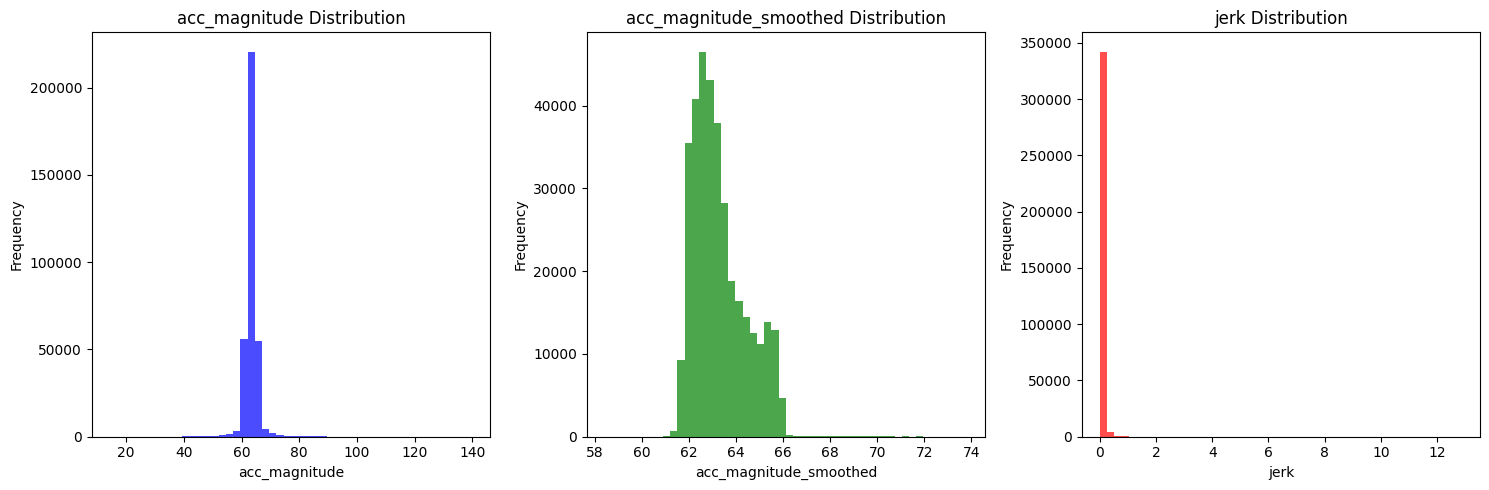

acc_magnitude statistics:
Mean: 63.29388526008296, Std: 2.4194026062800686, Min: 14.416787090055815, Max: 139.86114766081394

acc_magnitude_smoothed statistics:
Mean: 63.29360799972824, Std: 1.1213700882455684, Min: 58.43773745919452, Max: 73.80506418939015

jerk statistics:
Mean: 0.022426622242512146, Std: 0.06792667933719608, Min: 0.0, Max: 12.888893742545285


In [23]:
import matplotlib.pyplot as plt

# Calculate acc_magnitude
acc_data = data[['ACC_X', 'ACC_Y', 'ACC_Z']].values
acc_centered = acc_data - np.array([0, 0, 1.0])  # Remove gravity
acc_magnitude = np.sqrt(np.sum(acc_centered ** 2, axis=1))

# Apply Kalman filter to smooth the acceleration magnitude
acc_magnitude_smoothed = kalman_filter(acc_magnitude)

# Calculate jerk
acc_diff = np.diff(acc_magnitude_smoothed, prepend=acc_magnitude_smoothed[0])
jerk = np.abs(acc_diff)

# Plot histograms
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(acc_magnitude, bins=50, color='blue', alpha=0.7)
plt.title('acc_magnitude Distribution')
plt.xlabel('acc_magnitude')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(acc_magnitude_smoothed, bins=50, color='green', alpha=0.7)
plt.title('acc_magnitude_smoothed Distribution')
plt.xlabel('acc_magnitude_smoothed')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(jerk, bins=50, color='red', alpha=0.7)
plt.title('jerk Distribution')
plt.xlabel('jerk')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Calculate basic statistics
print("acc_magnitude statistics:")
print(f"Mean: {np.mean(acc_magnitude)}, Std: {np.std(acc_magnitude)}, Min: {np.min(acc_magnitude)}, Max: {np.max(acc_magnitude)}")

print("\nacc_magnitude_smoothed statistics:")
print(f"Mean: {np.mean(acc_magnitude_smoothed)}, Std: {np.std(acc_magnitude_smoothed)}, Min: {np.min(acc_magnitude_smoothed)}, Max: {np.max(acc_magnitude_smoothed)}")

print("\njerk statistics:")
print(f"Mean: {np.mean(jerk)}, Std: {np.std(jerk)}, Min: {np.min(jerk)}, Max: {np.max(jerk)}")

In [24]:
detect_motion(acc_data)

acc_magnitude_smoothed: [73.80506419 60.91617045 58.43773746 ... 65.28622427 65.27393767
 65.32921357]
jerk: [0.00000000e+00 1.28888937e+01 2.47843299e+00 ... 1.91584230e-02
 1.22866006e-02 5.52759027e-02]
motion_mask: [ True  True  True ...  True  True  True]
Motion mask counts: True = 347472, False = 0
smoothed: [0.5     0.53125 0.5625  ... 0.59375 0.5625  0.53125]


array([False,  True,  True, ...,  True,  True,  True], shape=(347472,))

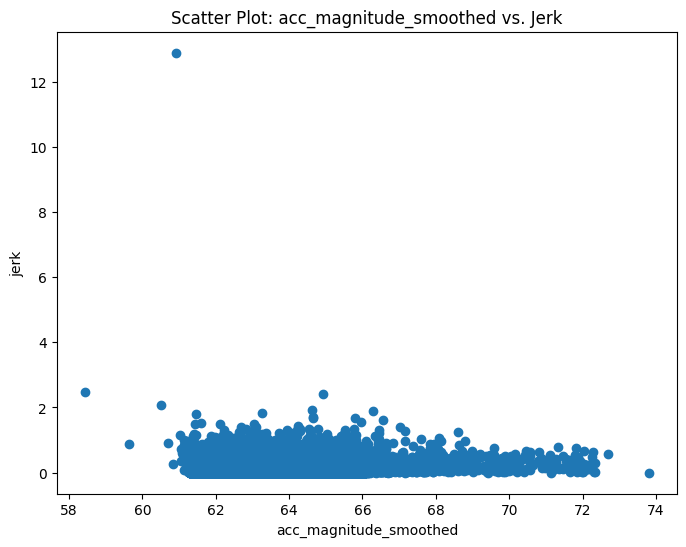

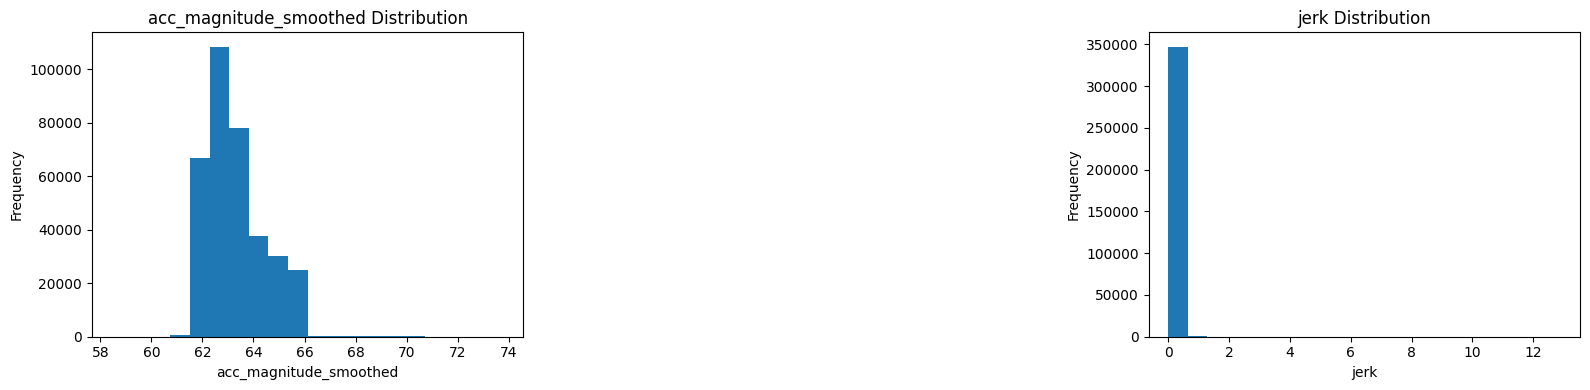

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Scatter plot of acc_magnitude_smoothed vs. jerk
plt.figure(figsize=(8, 6))
plt.scatter(acc_magnitude_smoothed, jerk)
plt.xlabel('acc_magnitude_smoothed')
plt.ylabel('jerk')
plt.title('Scatter Plot: acc_magnitude_smoothed vs. Jerk')
plt.show()

# Plot distributions
plt.figure(figsize=(16, 4))

# acc_magnitude_smoothed distribution
plt.subplot(1, 3, 1)
plt.hist(acc_magnitude_smoothed, bins=20)
plt.xlabel('acc_magnitude_smoothed')
plt.ylabel('Frequency')
plt.title('acc_magnitude_smoothed Distribution')

# jerk distribution 
plt.subplot(1, 3, 3)
plt.hist(jerk, bins=20)
plt.xlabel('jerk')
plt.ylabel('Frequency')
plt.title('jerk Distribution')

plt.tight_layout()
plt.show()

Based on the visualizations, I am experimenting with the following combinations of acc_threshold and jerk_threshold:

1. acc_threshold: 60-65, jerk_threshold: 1-2
   - The acc_magnitude_smoothed distribution shows most values are in the 60-65 range, so this aligns with the typical behavior.
   - The jerk distribution has a long tail, but the majority of values are under 2, so a threshold in this range can help capture meaningful motion without too many false positives.

2. acc_threshold: 62-66, jerk_threshold: 1.5-2.5
   - This slightly higher range for acc_threshold may help reduce false positives from the peak in the acc_magnitude_smoothed distribution.
   - The jerk_threshold range is expanded to 1.5-2.5 to balance sensitivity and specificity.

3. acc_threshold: 58-62, jerk_threshold: 0.5-1.5
   - This lower acc_threshold range may capture more subtle motion, at the cost of potentially more false positives.
   - The jerk_threshold range is lowered to 0.5-1.5 to compensate and maintain a reasonable balance.

The scatter plot shows a clear inverse relationship between acc_magnitude_smoothed and jerk, so experimenting with different combinations of thresholds can help you find the right balance for your motion detection needs.

I am starting with the first set of thresholds (60-65 for acc, 1-2 for jerk) and then adjusting as needed based on the performance of your stress detection model. Let me know if you have any other questions!

Experimenting combinations :
- acc_threshold: 62, jerk_threshold: 1.5
- acc_threshold: 64, jerk_threshold: 2.0
- acc_threshold: 60, jerk_threshold: 1.0

# Determinig Quality threshold